In [1]:
import cv2
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

import os
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize' : (22, 10)})
sns.set_style("darkgrid", {'axes.grid' : True})

In [2]:
def showImg(img, cmap=None):
    
    plt.imshow(img, cmap=cmap, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

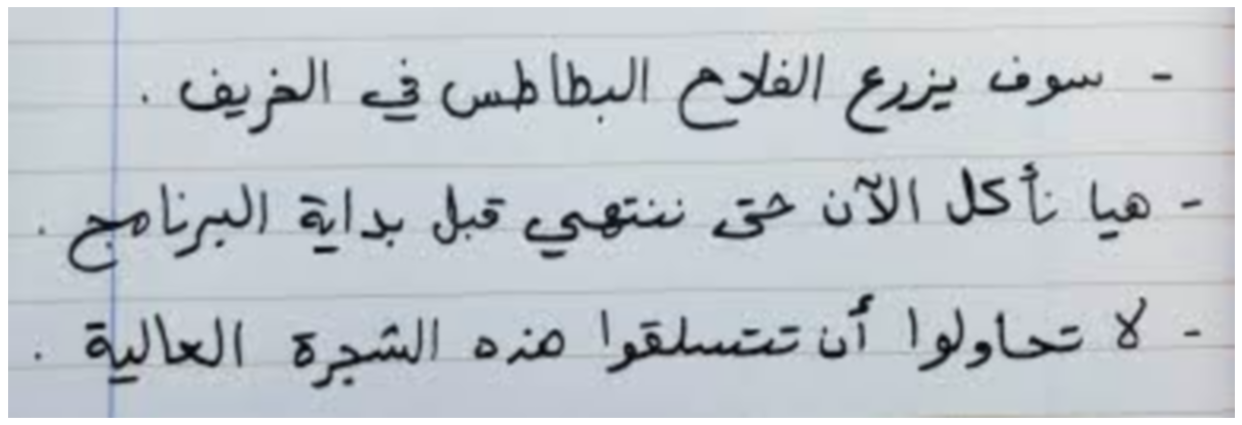

In [3]:
img1 = cv2.imread('hand_written.jpg') 
showImg(img1, cmap='gray')

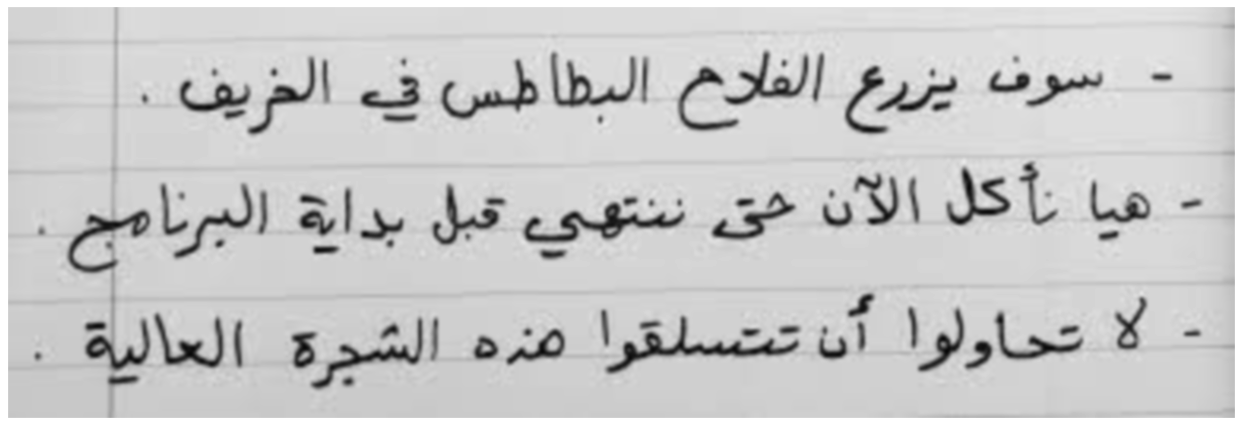

In [4]:
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
showImg(img2, cmap='gray')

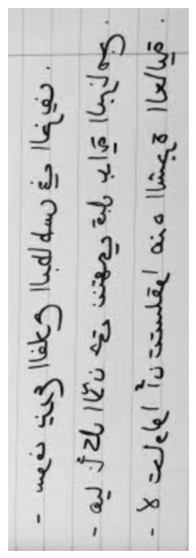

In [5]:
img3 = np.transpose(img2)
showImg(img3, cmap='gray')

In [6]:
def createKernel(kernelSize, sigma, theta):
    "create anisotropic filter kernel according to given parameters"
    assert kernelSize % 2 # must be odd size
    halfSize = kernelSize // 2

    kernel = np.zeros([kernelSize, kernelSize])
    sigmaX = sigma
    sigmaY = sigma * theta

    for i in range(kernelSize):
        for j in range(kernelSize):
            x = i - halfSize
            y = j - halfSize

            expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
            xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
            yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)

            kernel[i, j] = (xTerm + yTerm) * expTerm

    kernel = kernel / np.sum(kernel)
    return kernel

In [7]:
kernelSize=9
sigma=4
theta=1.5
#25, 0.8, 3.5

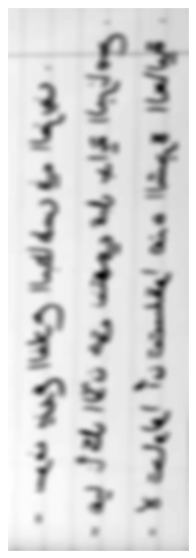

In [8]:
imgFiltered1 = cv2.filter2D(img3, -1, createKernel(kernelSize, sigma, theta), borderType=cv2.BORDER_REPLICATE)
showImg(imgFiltered1, cmap='gray')

In [9]:
def applySummFunctin(img):
    res = np.sum(img, axis = 0)    #  summ elements in columns
    return res

In [10]:
def normalize(img):
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s>0 else img
    return img
img4 = normalize(imgFiltered1)

In [11]:
(m, s) = cv2.meanStdDev(imgFiltered1)
m[0][0]

197.96021015067407

In [12]:
summ=applySummFunctin(img4)
print(summ.ndim)
print(summ.shape)

1
(130,)


In [13]:
def smooth(x, window_len=11, window='hanning'):
#     if x.ndim != 1:
#         raise ValueError("smooth only accepts 1 dimension arrays.") 
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.") 
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'") 
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    return y

In [14]:
from scipy.signal import argrelmin

windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
smoothed = smooth(summ, 35)
mins = argrelmin(smoothed, order=2)
arr_mins = np.array(mins)

In [15]:
def crop_text_to_lines(text, blanks):
    x1 = 0
    y = 0
    lines = []
    for i, blank in enumerate(blanks):
        x2 = blank
        print("x1=", x1, ", x2=", x2, ", Diff= ", x2-x1)
        line = text[:, x1:x2]
        lines.append(line)
        x1 = blank
    return lines
    

In [16]:
def display_lines(lines_arr, orient='vertical'):
    plt.figure(figsize=(30, 30))
    if not orient in ['vertical', 'horizontal']:
        raise ValueError("Orientation is on of 'vertical', 'horizontal', defaul = 'vertical'") 
    if orient == 'vertical': 
        for i, l in enumerate(lines_arr):
            line = l
            plt.subplot(2, 10, i+1)  # A grid of 2 rows x 10 columns
            plt.axis('off')
            plt.title("Line #{0}".format(i))
            _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    else:
            for i, l in enumerate(lines_arr):
                line = l
                plt.subplot(40, 1, i+1)  # A grid of 40 rows x 1 columns
                plt.axis('off')
                plt.title("Line #{0}".format(i))
                _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
                plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [17]:
found_lines = crop_text_to_lines(img3, arr_mins[0])
found_lines[2]

x1= 0 , x2= 44 , Diff=  44
x1= 44 , x2= 84 , Diff=  40
x1= 84 , x2= 125 , Diff=  41


array([[204, 204, 204, ..., 198, 198, 198],
       [204, 204, 204, ..., 198, 198, 198],
       [205, 205, 205, ..., 198, 198, 198],
       ...,
       [199, 194, 183, ..., 194, 200, 198],
       [195, 190, 180, ..., 190, 197, 194],
       [192, 186, 176, ..., 186, 193, 191]], dtype=uint8)

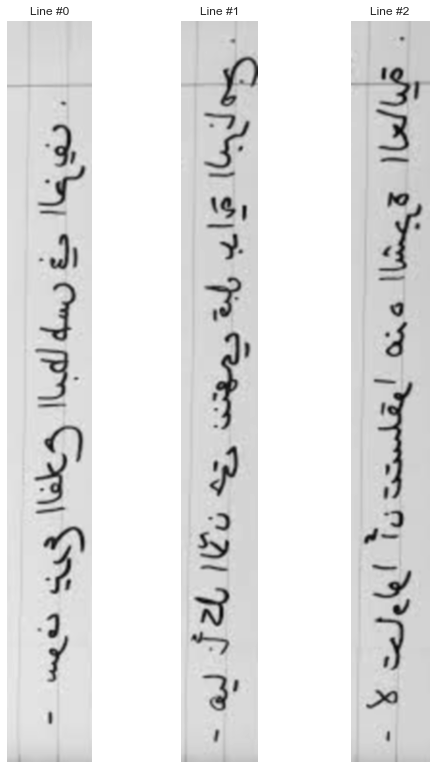

In [18]:
display_lines(found_lines)

In [19]:
def transpose_lines(lines):
    res = []
    for l in lines:
        line = np.transpose(l)
        res.append(line)
    return res

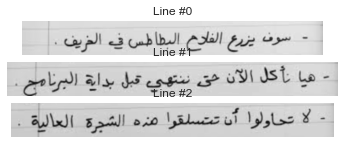

In [20]:
res_lines = transpose_lines(found_lines)
display_lines(res_lines, 'horizontal')

In [21]:
img3_1 = cv2.imread('hand_written.jpg') 


x1= 0 , x2= 44 , Diff=  44
x1= 44 , x2= 84 , Diff=  40
x1= 84 , x2= 125 , Diff=  41


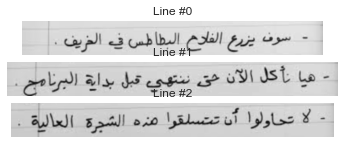

In [22]:
img3_2 = cv2.cvtColor(img3_1, cv2.COLOR_BGR2GRAY)
img3_3 = np.transpose(img3_2)
k = createKernel(kernelSize, sigma, theta)
imgFiltered3 = cv2.filter2D(img3_3, -1, k, borderType=cv2.BORDER_REPLICATE)
img3_4 = normalize(imgFiltered3)
summ3 = applySummFunctin(img3_4)
smoothed3 = smooth(summ3, 35)
mins3 = argrelmin(smoothed3, order=2)
arr_mins3 = np.array(mins3)
found_lines3 = crop_text_to_lines(img3_3, arr_mins3[0])
res_lines3 = transpose_lines(found_lines3)
display_lines(res_lines3, 'horizontal')

# final function 

In [23]:
def split_lines_from_image(img_path):
    img3_1 = cv2.imread(img_path)    
    img3_2 = cv2.cvtColor(img3_1, cv2.COLOR_BGR2GRAY)
    img3_3 = np.transpose(img3_2)
    k = createKernel(kernelSize, sigma, theta)
    imgFiltered3 = cv2.filter2D(img3_3, -1, k, borderType=cv2.BORDER_REPLICATE)
    img3_4 = normalize(imgFiltered3)
    summ3 = applySummFunctin(img3_4)
    smoothed3 = smooth(summ3, 35)
    mins3 = argrelmin(smoothed3, order=2)
    arr_mins3 = np.array(mins3)
    found_lines3 = crop_text_to_lines(img3_3, arr_mins3[0])
    res_lines3 = transpose_lines(found_lines3)
    #display_lines(res_lines3, 'horizontal')
    return res_lines3

In [24]:
one = split_lines_from_image('t.jpg')[1]
cv2.imshow("Zeros matx", one)

cv2.waitKey(0)

cv2.imwrite("E:/images/splitted/00.jpg", one)

x1= 0 , x2= 83 , Diff=  83
x1= 83 , x2= 136 , Diff=  53
x1= 136 , x2= 189 , Diff=  53
x1= 189 , x2= 242 , Diff=  53
x1= 242 , x2= 296 , Diff=  54
x1= 296 , x2= 349 , Diff=  53
x1= 349 , x2= 403 , Diff=  54
x1= 403 , x2= 458 , Diff=  55
x1= 458 , x2= 510 , Diff=  52
x1= 510 , x2= 562 , Diff=  52
x1= 562 , x2= 614 , Diff=  52
x1= 614 , x2= 668 , Diff=  54
x1= 668 , x2= 719 , Diff=  51
x1= 719 , x2= 769 , Diff=  50
x1= 769 , x2= 823 , Diff=  54
x1= 823 , x2= 873 , Diff=  50
x1= 873 , x2= 925 , Diff=  52
x1= 925 , x2= 972 , Diff=  47
x1= 972 , x2= 1021 , Diff=  49
x1= 1021 , x2= 1070 , Diff=  49
x1= 1070 , x2= 1121 , Diff=  51
x1= 1121 , x2= 1172 , Diff=  51
x1= 1172 , x2= 1220 , Diff=  48
x1= 1220 , x2= 1267 , Diff=  47


False

In [25]:
imgs=os.listdir('E:/images')
for i in imgs:
    r=split_lines_from_image('E:/images/'+i)
    for j in range(len(r)-1) :
        print(j)
        x= r[j]
        print("x",x)
        string="E:/splitted_images/{}{} "
        cv2.imwrite(string.format(j,i),x)


x1= 0 , x2= 66 , Diff=  66
x1= 66 , x2= 119 , Diff=  53
x1= 119 , x2= 140 , Diff=  21
x1= 140 , x2= 165 , Diff=  25
x1= 165 , x2= 191 , Diff=  26
x1= 191 , x2= 215 , Diff=  24
x1= 215 , x2= 241 , Diff=  26
x1= 241 , x2= 265 , Diff=  24
x1= 265 , x2= 288 , Diff=  23
x1= 288 , x2= 315 , Diff=  27
x1= 315 , x2= 344 , Diff=  29
x1= 344 , x2= 389 , Diff=  45
x1= 389 , x2= 413 , Diff=  24
x1= 413 , x2= 438 , Diff=  25
x1= 438 , x2= 465 , Diff=  27
x1= 465 , x2= 486 , Diff=  21
x1= 486 , x2= 512 , Diff=  26
x1= 512 , x2= 537 , Diff=  25
x1= 537 , x2= 561 , Diff=  24
x1= 561 , x2= 586 , Diff=  25
x1= 586 , x2= 611 , Diff=  25
x1= 611 , x2= 635 , Diff=  24
x1= 635 , x2= 661 , Diff=  26
x1= 661 , x2= 684 , Diff=  23
x1= 684 , x2= 709 , Diff=  25
0
x [[162 163 165 ... 242 229 191]
 [165 166 168 ... 242 230 194]
 [163 164 166 ... 242 232 198]
 ...
 [158 159 161 ... 228 230 231]
 [159 161 164 ... 227 229 231]
 [158 159 161 ... 228 230 232]]
1
x [[157 158 159 ... 228 229 231]
 [161 161 160 ... 225 2

x1= 158 , x2= 219 , Diff=  61
x1= 219 , x2= 279 , Diff=  60
x1= 279 , x2= 339 , Diff=  60
x1= 339 , x2= 400 , Diff=  61
x1= 400 , x2= 460 , Diff=  60
x1= 460 , x2= 521 , Diff=  61
x1= 521 , x2= 579 , Diff=  58
x1= 579 , x2= 642 , Diff=  63
x1= 642 , x2= 702 , Diff=  60
x1= 702 , x2= 764 , Diff=  62
x1= 764 , x2= 826 , Diff=  62
x1= 826 , x2= 875 , Diff=  49
x1= 875 , x2= 944 , Diff=  69
x1= 944 , x2= 1005 , Diff=  61
x1= 1005 , x2= 1013 , Diff=  8
x1= 1013 , x2= 1079 , Diff=  66
x1= 1079 , x2= 1148 , Diff=  69
x1= 1148 , x2= 1296 , Diff=  148
0
x [[219 212 208 ... 213 212 208]
 [221 214 210 ... 213 213 209]
 [224 217 212 ... 214 214 211]
 ...
 [228 228 228 ... 209 211 212]
 [227 227 227 ... 210 212 213]
 [226 226 226 ... 209 213 215]]
1
x [[226 226 226 ... 209 213 216]
 [228 228 228 ... 207 212 216]
 [228 228 228 ... 206 211 216]
 ...
 [225 225 225 ... 211 211 212]
 [225 225 225 ... 211 211 211]
 [225 225 225 ... 209 209 209]]
2
x [[225 225 225 ... 208 207 207]
 [225 225 225 ... 206 20

x1= 420 , x2= 471 , Diff=  51
x1= 471 , x2= 525 , Diff=  54
x1= 525 , x2= 579 , Diff=  54
x1= 579 , x2= 629 , Diff=  50
x1= 629 , x2= 683 , Diff=  54
x1= 683 , x2= 733 , Diff=  50
x1= 733 , x2= 786 , Diff=  53
x1= 786 , x2= 839 , Diff=  53
x1= 839 , x2= 893 , Diff=  54
x1= 893 , x2= 947 , Diff=  54
x1= 947 , x2= 1000 , Diff=  53
x1= 1000 , x2= 1053 , Diff=  53
x1= 1053 , x2= 1110 , Diff=  57
x1= 1110 , x2= 1166 , Diff=  56
x1= 1166 , x2= 1223 , Diff=  57
x1= 1223 , x2= 1278 , Diff=  55
0
x [[86 88 91 ... 85 87 90]
 [85 87 89 ... 88 88 88]
 [85 87 89 ... 90 89 88]
 ...
 [90 90 90 ... 93 94 95]
 [87 87 87 ... 90 89 89]
 [95 93 91 ... 89 89 90]]
1
x [[ 94  92  90 ...  89  90  90]
 [ 92  91  89 ...  89  90  91]
 [ 91  90  89 ...  90  90  91]
 ...
 [207 207 208 ... 167 175 185]
 [204 204 204 ... 163 172 180]
 [205 205 204 ... 160 167 175]]
2
x [[208 207 206 ... 159 163 170]
 [214 213 211 ... 162 166 171]
 [220 219 217 ... 168 173 177]
 ...
 [199 198 198 ... 178 174 172]
 [203 203 203 ... 18

x1= 0 , x2= 17 , Diff=  17
x1= 17 , x2= 65 , Diff=  48
x1= 65 , x2= 120 , Diff=  55
x1= 120 , x2= 175 , Diff=  55
x1= 175 , x2= 233 , Diff=  58
x1= 233 , x2= 285 , Diff=  52
x1= 285 , x2= 343 , Diff=  58
x1= 343 , x2= 396 , Diff=  53
x1= 396 , x2= 454 , Diff=  58
x1= 454 , x2= 504 , Diff=  50
x1= 504 , x2= 561 , Diff=  57
x1= 561 , x2= 614 , Diff=  53
x1= 614 , x2= 679 , Diff=  65
x1= 679 , x2= 720 , Diff=  41
x1= 720 , x2= 836 , Diff=  116
x1= 836 , x2= 892 , Diff=  56
x1= 892 , x2= 941 , Diff=  49
x1= 941 , x2= 1048 , Diff=  107
x1= 1048 , x2= 1181 , Diff=  133
x1= 1181 , x2= 1213 , Diff=  32
x1= 1213 , x2= 1296 , Diff=  83
0
x [[233 229 226 ... 206 206 207]
 [227 229 229 ... 207 206 207]
 [218 229 234 ... 208 207 207]
 ...
 [219 212 212 ... 209 208 208]
 [211 204 212 ... 210 209 210]
 [218 215 216 ... 212 210 210]]
1
x [[210 212 216 ... 211 209 209]
 [207 211 214 ... 210 208 209]
 [210 212 210 ... 211 209 211]
 ...
 [181 181 181 ... 209 205 202]
 [156 156 156 ... 205 200 196]
 [192 

x1= 68 , x2= 120 , Diff=  52
x1= 120 , x2= 176 , Diff=  56
x1= 176 , x2= 229 , Diff=  53
x1= 229 , x2= 286 , Diff=  57
x1= 286 , x2= 337 , Diff=  51
x1= 337 , x2= 394 , Diff=  57
x1= 394 , x2= 449 , Diff=  55
x1= 449 , x2= 506 , Diff=  57
x1= 506 , x2= 559 , Diff=  53
x1= 559 , x2= 619 , Diff=  60
x1= 619 , x2= 671 , Diff=  52
x1= 671 , x2= 731 , Diff=  60
x1= 731 , x2= 784 , Diff=  53
x1= 784 , x2= 845 , Diff=  61
x1= 845 , x2= 902 , Diff=  57
x1= 902 , x2= 958 , Diff=  56
x1= 958 , x2= 1017 , Diff=  59
x1= 1017 , x2= 1081 , Diff=  64
x1= 1081 , x2= 1137 , Diff=  56
x1= 1137 , x2= 1203 , Diff=  66
x1= 1203 , x2= 1257 , Diff=  54
x1= 1257 , x2= 1296 , Diff=  39
0
x [[212 213 213 ... 192 194 196]
 [212 212 213 ... 192 193 195]
 [211 211 212 ... 191 192 193]
 ...
 [213 213 214 ... 193 194 194]
 [213 214 214 ... 193 193 194]
 [209 211 212 ... 196 193 191]]
1
x [[211 212 212 ... 196 194 192]
 [213 213 212 ... 197 195 193]
 [214 214 214 ... 197 195 194]
 ...
 [212 211 211 ... 196 196 196]
 

x1= 0 , x2= 81 , Diff=  81
x1= 81 , x2= 141 , Diff=  60
x1= 141 , x2= 200 , Diff=  59
x1= 200 , x2= 262 , Diff=  62
x1= 262 , x2= 322 , Diff=  60
x1= 322 , x2= 383 , Diff=  61
x1= 383 , x2= 445 , Diff=  62
x1= 445 , x2= 502 , Diff=  57
x1= 502 , x2= 564 , Diff=  62
x1= 564 , x2= 623 , Diff=  59
x1= 623 , x2= 687 , Diff=  64
x1= 687 , x2= 748 , Diff=  61
x1= 748 , x2= 809 , Diff=  61
x1= 809 , x2= 871 , Diff=  62
x1= 871 , x2= 929 , Diff=  58
x1= 929 , x2= 992 , Diff=  63
x1= 992 , x2= 1053 , Diff=  61
x1= 1053 , x2= 1117 , Diff=  64
x1= 1117 , x2= 1182 , Diff=  65
x1= 1182 , x2= 1243 , Diff=  61
x1= 1243 , x2= 1296 , Diff=  53
0
x [[223 224 225 ... 210 209 208]
 [223 224 225 ... 210 210 208]
 [223 224 225 ... 210 210 210]
 ...
 [211 214 217 ... 212 212 212]
 [212 215 217 ... 212 212 212]
 [218 220 220 ... 211 211 211]]
1
x [[211 213 212 ... 211 211 211]
 [201 201 199 ... 212 212 212]
 [203 202 199 ... 212 212 212]
 ...
 [203 203 203 ... 210 210 210]
 [207 202 202 ... 210 212 213]
 [221

x1= 0 , x2= 13 , Diff=  13
x1= 13 , x2= 21 , Diff=  8
x1= 21 , x2= 86 , Diff=  65
x1= 86 , x2= 137 , Diff=  51
x1= 137 , x2= 233 , Diff=  96
x1= 233 , x2= 291 , Diff=  58
x1= 291 , x2= 374 , Diff=  83
x1= 374 , x2= 442 , Diff=  68
x1= 442 , x2= 492 , Diff=  50
x1= 492 , x2= 545 , Diff=  53
x1= 545 , x2= 595 , Diff=  50
x1= 595 , x2= 649 , Diff=  54
x1= 649 , x2= 704 , Diff=  55
x1= 704 , x2= 760 , Diff=  56
x1= 760 , x2= 808 , Diff=  48
x1= 808 , x2= 864 , Diff=  56
x1= 864 , x2= 918 , Diff=  54
x1= 918 , x2= 937 , Diff=  19
x1= 937 , x2= 1031 , Diff=  94
x1= 1031 , x2= 1083 , Diff=  52
x1= 1083 , x2= 1128 , Diff=  45
x1= 1128 , x2= 1185 , Diff=  57
x1= 1185 , x2= 1242 , Diff=  57
x1= 1242 , x2= 1296 , Diff=  54
0
x [[223 223 222 ... 177 169 164]
 [223 223 223 ... 177 169 163]
 [223 223 223 ... 176 168 163]
 ...
 [222 221 221 ... 175 169 165]
 [222 221 221 ... 174 170 167]
 [223 223 222 ... 173 169 166]]
1
x [[223 225 224 ... 172 168 166]
 [222 226 225 ... 173 169 168]
 [221 225 225 ..

x1= 0 , x2= 83 , Diff=  83
x1= 83 , x2= 136 , Diff=  53
x1= 136 , x2= 189 , Diff=  53
x1= 189 , x2= 242 , Diff=  53
x1= 242 , x2= 296 , Diff=  54
x1= 296 , x2= 349 , Diff=  53
x1= 349 , x2= 403 , Diff=  54
x1= 403 , x2= 458 , Diff=  55
x1= 458 , x2= 510 , Diff=  52
x1= 510 , x2= 562 , Diff=  52
x1= 562 , x2= 614 , Diff=  52
x1= 614 , x2= 668 , Diff=  54
x1= 668 , x2= 719 , Diff=  51
x1= 719 , x2= 769 , Diff=  50
x1= 769 , x2= 823 , Diff=  54
x1= 823 , x2= 873 , Diff=  50
x1= 873 , x2= 925 , Diff=  52
x1= 925 , x2= 972 , Diff=  47
x1= 972 , x2= 1021 , Diff=  49
x1= 1021 , x2= 1070 , Diff=  49
x1= 1070 , x2= 1121 , Diff=  51
x1= 1121 , x2= 1172 , Diff=  51
x1= 1172 , x2= 1220 , Diff=  48
x1= 1220 , x2= 1267 , Diff=  47
0
x [[154 180 190 ... 205 205 206]
 [152 179 188 ... 205 205 205]
 [153 179 189 ... 205 205 204]
 ...
 [161 162 164 ... 211 209 212]
 [164 165 167 ... 210 208 210]
 [161 162 163 ... 208 206 207]]
1
x [[154 154 156 ... 203 200 202]
 [153 154 155 ... 194 192 195]
 [162 162 1

# renaming files

In [26]:
# files=os.listdir('E:/splitted_images')
# print(len(files))

# for i in range (len(files)):
#     os.rename(r'E:/splitted_images/{}'.format(files[i]),r'E:/splitted_images/{}.jpg'.format(i))

# annotationg images with ArabicOcr (not working well)

In [27]:
!pip install ArabicOcr

In [28]:
# from ArabicOcr import arabicocr
# results=arabicocr.arabic_ocr('E:/splitted_images/14.jpg','E:/splitted_images/nu.jpg')

In [29]:
# words=[] 
# for i in range(len(results)):  
#     word=results[i][1] 
# words.append(word) 
# with open ('file.txt','w',encoding='utf-8')as myfile: 
#     myfile.write(str(words))

# ArabicOcr doesnt work well with hand writing images 

# preparing Data 

In [30]:
l = os.listdir('E:/my data/splitted_images')
df=pd.DataFrame(l ,columns=['FILENAME'])
df['IDENTITY']=np.ones(len(l))
df

,FILENAME,IDENTITY
0,0.jpg,1.0
1,1.jpg,1.0
2,10.jpg,1.0
3,100.jpg,1.0
4,101.jpg,1.0
...,...,...
339,95.jpg,1.0
340,96.jpg,1.0
341,97.jpg,1.0
342,98.jpg,1.0


In [31]:
dic={}
with open('E:/my data/text.txt', 'r' , encoding="utf8") as f:
        lines = f.readlines()
        for line in lines:
            sent=line.split(':')[1][:-1]
            img=line.split(':')[0].split(';')[0]
            dic[img]=sent
dic

{'0.jpg': 'بسم الله الرحمن الرحيم',
 '1.jpg': 'سورة الفاتحة',
 '2.jpg': 'سوف يزرع الفلاح البطاطس في الخريف',
 '3.jpg': 'إذا كنت تستطيع قراءة هذا،كما تعلمونالعربية و من هذه',
 '4.jpg': 'ما أكتب العربية كثيرا كما ترون ',
 '5.jpg': 'اسم الفاعل هو اسم يشتق من الفعل',
 '6.jpg': 'الذين ءامنو و عملو الصالحات طوبي لهم و حسن مئاب',
 '7.jpg': 'الذين ءامنو و عملو الصالحات طوبي لهم و حسن مئاب29',
 '8.jpg': '',
 '9.jpg': 'أفمن يعلم أنما أنزل إليك من ربك الحق كمن هو أعمي',
 '10.jpg': 'أفمن يعلم أنما أنزل إليك من ربك الحق كمن هو أعمي',
 '11.jpg': 'و لينعم بثوب العافية،و أن يسبغ علي جلالتكم بالشفاء',
 '12.jpg': 'إلي المقام السامي الكريم',
 '13.jpg': '',
 '14.jpg': 'إنه رجل جرئ العقل مفطور علي المشاجرة',
 '15.jpg': 'قائده في الأزهر .. لا يتردد في مشيته',
 '16.jpg': 'أطعمة بلدهم',
 '17.jpg': 'إلا كانو به يستهزؤن 11 كذلك نسلكه في قلوب المجرمين',
 '18.jpg': 'أخبرتك أني لا أريد أي وجبة',
 '19.jpg': 'الدنيا علي الاخره و يصدون عن السبيل و يبغونها عوجا ',
 '20.jpg': 'و ذرية و ما كان لرسول أن يأتي بايه إلا بإذ

In [32]:
df['FILENAME']=dic.keys()
df['IDENTITY']=dic.values()

In [33]:
df

,FILENAME,IDENTITY
0,0.jpg,بسم الله الرحمن الرحيم
1,1.jpg,سورة الفاتحة
2,2.jpg,سوف يزرع الفلاح البطاطس في الخريف
3,3.jpg,إذا كنت تستطيع قراءة هذا،كما تعلمونالعربية و م...
4,4.jpg,ما أكتب العربية كثيرا كما ترون
...,...,...
339,339.jpg,و لقد أرسلنا رسلا من قبلك و جعلنا لهم أزواجا
340,340.jpg,من كل باب 23 سلام عليكم بما صبرتم فنعم عقبي ال...
341,341.jpg,يتذكر أولو الألباب 19 اللذين يوفون بعهد الله و...
342,342.jpg,من كل باب 23 سلام عليكم بما صبرتم فنعم عقبي ال...


In [34]:
df.to_csv('E:/my data/my_data.csv')

# word segmentation

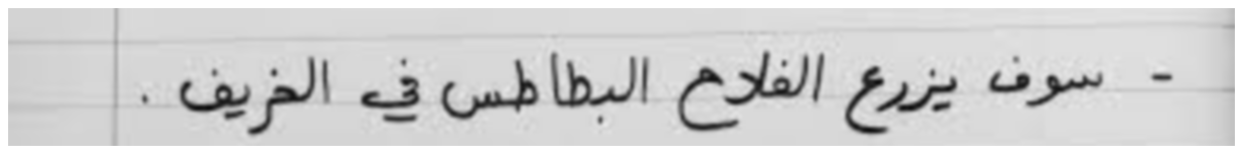

In [43]:
img1 = cv2.imread('E:/my data/splitted_images/2.jpg') 
h = img1.shape[0]
factor = 50 / h
cv2.resize(img1, dsize=None, fx=factor, fy=factor)
showImg(img1, cmap='gray')

In [ ]:
# (_, imgThres) = cv2.threshold(img1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# imgThres = 255 - imgThres
# showImg(imgThres, cmap='gray')

In [ ]:
# if cv2.__version__.startswith('3.'):
    
#     (_, components, _) = cv2.findContours(imgThres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# else:
#     # cv2.RETR_EXTERNAL or cv2.RETR_LIST - ???
#     (components, _) = cv2.findContours(imgThres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

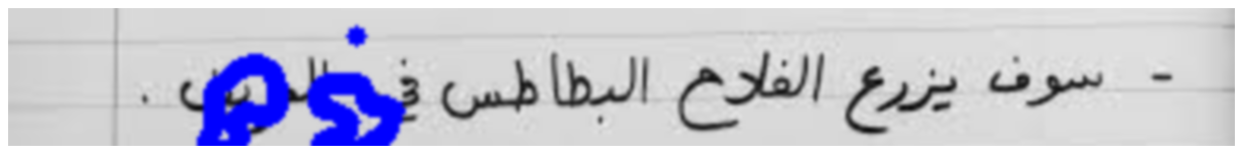

In [38]:
(components, _) = cv2.findContours(imgThres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
showImg(cv2.drawContours(img1, components, -1, (0,0,255), 5))

# word segmetation with opencv (countours) doesnt work well 